In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [2]:
marketing_campaign = pd.read_csv("marketing_campaign.csv", sep='\t')

Since in the documentation, we only have explanation for the first 10 variables, we drop others

In [3]:
cleaned_marketing_campaign = marketing_campaign.copy()
cleaned_marketing_campaign['Mnt/Income'] = marketing_campaign['MntWines'] / marketing_campaign['Income']
cleaned_marketing_campaign['WinePrice/AllPrice'] = marketing_campaign['MntWines'] / \
(marketing_campaign['MntWines'] + marketing_campaign['MntFruits'] + marketing_campaign['MntMeatProducts']\
+ marketing_campaign['MntFishProducts'] + marketing_campaign['MntSweetProducts'] + marketing_campaign['MntGoldProds'])
cleaned_marketing_campaign = cleaned_marketing_campaign.drop(columns = ['NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth'\
                                           ,'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', \
                                           'AcceptedCmp5', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',\
                                          'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'NumWebPurchases', \
                                          'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'])

Now we identify the type of each variable.

ID is nominal.<br>
Year_Birth is ordinal.<br>
Education is nominal.<br>
Marital_Status is nominal.<br>
Income is numerical.<br>
Kidhome is numerical.<br>
Teenhome is numerical.<br>
Dt_Customer is ordinal.<br>
Recency is numerical.<br>
MintWine is numerical.<br>


In [4]:
cleaned_marketing_campaign.dtypes

ID                      int64
Year_Birth              int64
Education              object
Marital_Status         object
Income                float64
Kidhome                 int64
Teenhome                int64
Dt_Customer            object
Recency                 int64
MntWines                int64
Mnt/Income            float64
WinePrice/AllPrice    float64
dtype: object

#### Then, we deal with the missing values.<br>

In [5]:
pd.isnull(cleaned_marketing_campaign).mean()

ID                    0.000000
Year_Birth            0.000000
Education             0.000000
Marital_Status        0.000000
Income                0.010714
Kidhome               0.000000
Teenhome              0.000000
Dt_Customer           0.000000
Recency               0.000000
MntWines              0.000000
Mnt/Income            0.010714
WinePrice/AllPrice    0.000000
dtype: float64

So, only Income contains missing values.<br>
For simplicity, we assume it to be missing completely at random. (We didn't do hypothesis test to test this since the main task of this project is clustering not missing type analysis). So, we just drop these.

In [6]:
cleaned_marketing_campaign = cleaned_marketing_campaign[~pd.isnull(cleaned_marketing_campaign["Income"])]

#### Now, we do some type conversion and feature engineering

We will drop ID column, since it means nothing in clustering

We will convert Year_Birth to age and standardize it.

In [7]:
age = 2021 - cleaned_marketing_campaign["Year_Birth"]
std_age = (age - np.mean(age))/np.std(age)

We will do One-hot encoding on Education

In [8]:
cleaned_marketing_campaign["Education"].value_counts()

Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64

In [9]:
Graduation = (cleaned_marketing_campaign["Education"] == "Graduation").astype(int)
PhD = (cleaned_marketing_campaign["Education"] == "PhD").astype(int)
Master = (cleaned_marketing_campaign["Education"] == "Master").astype(int)
Cycle = (cleaned_marketing_campaign["Education"] == "2n Cycle").astype(int)
Basic = (cleaned_marketing_campaign["Education"] == "Bsic").astype(int)

We will do One-hot encoding on Marital status

In [10]:
cleaned_marketing_campaign["Marital_Status"].value_counts()

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64

In [11]:
Married = (cleaned_marketing_campaign["Marital_Status"] == "Married").astype(int)
Together = (cleaned_marketing_campaign["Marital_Status"] == "Together").astype(int)
Single = (cleaned_marketing_campaign["Marital_Status"] == "Single").astype(int)
Divorced = (cleaned_marketing_campaign["Marital_Status"] == "Divorced").astype(int)
Widow =  (cleaned_marketing_campaign["Marital_Status"] == "Widow").astype(int)
Others = ((cleaned_marketing_campaign["Marital_Status"] == "Alone")|(cleaned_marketing_campaign["Marital_Status"] == "Absurd")|(cleaned_marketing_campaign["Marital_Status"] == "YOLO")).astype(int)

We standardize income, kids and teens

In [12]:
std_income = (cleaned_marketing_campaign["Income"] - np.mean(cleaned_marketing_campaign["Income"]))/np.std(cleaned_marketing_campaign["Income"])

In [13]:
std_kid = (cleaned_marketing_campaign["Kidhome"] - np.mean(cleaned_marketing_campaign["Kidhome"]))/np.std(cleaned_marketing_campaign["Kidhome"])

In [14]:
std_teen = (cleaned_marketing_campaign["Teenhome"] - np.mean(cleaned_marketing_campaign["Teenhome"]))/np.std(cleaned_marketing_campaign["Teenhome"])

For Dt_Customer, we first find the first enrolled customer and calculate the day difference between others and the first enrolled customer. We standarize it.

In [15]:
min_date = min(cleaned_marketing_campaign["Dt_Customer"].apply(lambda x: pd.to_datetime(x)))

In [16]:
date1 = cleaned_marketing_campaign["Dt_Customer"].apply(lambda x: pd.to_datetime(x))

In [17]:
day_diff = (date1 - min_date).astype(str).apply(lambda x: x.split()[0]).astype(int)

In [18]:
std_day_diff = (day_diff - np.mean(day_diff))/np.std(day_diff)

We standardize Recency

In [19]:
std_recency = (cleaned_marketing_campaign["Recency"] - np.mean(cleaned_marketing_campaign["Recency"]))/np.std(cleaned_marketing_campaign["Recency"])

In [56]:
std_mntwines = (cleaned_marketing_campaign["MntWines"] - np.mean(cleaned_marketing_campaign["MntWines"]))/\
                np.std(cleaned_marketing_campaign["MntWines"])

3.5223189165937967

In [64]:
std_MntoverIncome = ((cleaned_marketing_campaign["Mnt/Income"] - np.mean(cleaned_marketing_campaign["Mnt/Income"]))\
              /np.std(cleaned_marketing_campaign["Mnt/Income"]))
std_MntoverIncome.mean()

1.31363031162778e-16

In [67]:
std_WinPoverAllP = ((cleaned_marketing_campaign["WinePrice/AllPrice"] - np.mean(cleaned_marketing_campaign["WinePrice/AllPrice"]))\
                 /np.std(cleaned_marketing_campaign["WinePrice/AllPrice"]))
std_WinPoverAllP.mean()

-5.525839513201442e-15

Output df

In [23]:
standardized_df = pd.DataFrame({"Age":std_age, "Income":std_income, "MntWines":std_mntwines,\
                                "Kids":std_kid, "Teens":std_teen, "Enroll_age":std_day_diff, \
                                "Recency":std_recency, "Graduation":Graduation, "PhD":PhD, \
                                "Master":Master, "Cycle":Cycle, "Basic":Basic, "Married":Married,\
                                "Together":Together, "Single":Single, "Divorced":Divorced, "Widow":Widow, \
                                "Others":Others, "Mnt/Income":std_MntoverIncome, "MntWines/AllProducts":\
                                std_WinPoverAllP})
standardized_df

,Age,Income,MntWines,Kids,Teens,Enroll_age,Recency,Graduation,PhD,Master,Cycle,Basic,Married,Together,Single,Divorced,Widow,Others,Mnt/Income,MntWines/AllProducts
0,0.986443,0.234063,0.978226,-0.823039,-0.928972,-1.974875,0.310532,1,0,0,0,0,0,0,1,0,0,0,1.325058,-0.288819
1,1.236801,-0.234559,-0.872024,1.039938,0.909066,1.665141,-0.380509,1,0,0,0,0,0,0,1,0,0,0,-0.964424,-0.224466
2,0.318822,0.769478,0.358511,-0.823039,-0.928972,0.172132,-0.795134,1,0,0,0,0,0,1,0,0,0,0,0.259344,0.395043
3,-1.266777,-1.017239,-0.872024,1.039938,-0.928972,1.923298,-0.795134,1,0,0,0,0,0,1,0,0,0,0,-0.926827,-1.099106
4,-1.016420,0.240221,-0.391671,1.039938,-0.928972,0.821827,1.554407,0,1,0,0,0,1,0,0,0,0,0,-0.379374,-0.213328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,0.151917,0.356642,1.197646,-0.823039,0.909066,-0.124749,-0.104093,1,0,0,0,0,1,0,0,0,0,0,1.466119,0.306384
2236,1.904422,0.467539,0.299208,2.902916,0.909066,1.940508,0.241428,0,1,0,0,0,0,1,0,0,0,0,0.343708,1.994325
2237,-1.016420,0.188091,1.787710,-0.823039,-0.928972,0.847643,1.450751,1,0,0,0,0,0,0,0,1,0,0,2.399171,1.194581
2238,1.069896,0.675388,0.364441,-0.823039,0.909066,0.843341,-1.417072,0,0,1,0,0,0,1,0,0,0,0,0.309122,0.214486


In [24]:
# drop categorical columns
Kmean_df = standardized_df.drop(['Graduation','PhD','Master','Cycle','Basic','Married','Together','Single',\
                                 'Divorced','Widow','Others'], axis=1)
Kmean_df = Kmean_df.reset_index(drop = True)
Kmean_df = Kmean_df.drop(['MntWines', 'Mnt/Income', 'MntWines/AllProducts', 'Income'], axis = 1)
Kmean_df

,Age,Kids,Teens,Enroll_age,Recency
0,0.986443,-0.823039,-0.928972,-1.974875,0.310532
1,1.236801,1.039938,0.909066,1.665141,-0.380509
2,0.318822,-0.823039,-0.928972,0.172132,-0.795134
3,-1.266777,1.039938,-0.928972,1.923298,-0.795134
4,-1.016420,1.039938,-0.928972,0.821827,1.554407
...,...,...,...,...,...
2211,0.151917,-0.823039,0.909066,-0.124749,-0.104093
2212,1.904422,2.902916,0.909066,1.940508,0.241428
2213,-1.016420,-0.823039,-0.928972,0.847643,1.450751
2214,1.069896,-0.823039,0.909066,0.843341,-1.417072


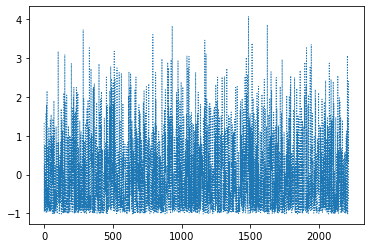

In [25]:
#plot the Mntwines/Income
plt.plot(np.arange(2216),standardized_df['Mnt/Income'],ls = 'dotted',lw=1)

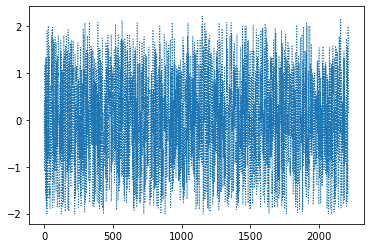

In [26]:
#plot the WinePrice/AllPrice
plt.plot(np.arange(2216),standardized_df['MntWines/AllProducts'],ls = 'dotted',lw=1)

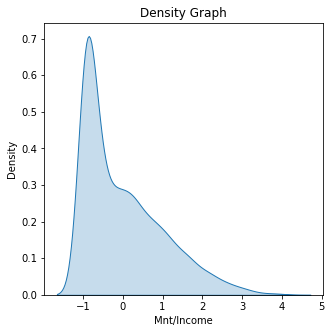

In [27]:
#density graph of the Mines/Income
plt.figure(figsize = (5,5))
plt.title('Density Graph')
sb.kdeplot(standardized_df['Mnt/Income'] , fill = True)
plt.show()

# Optimal K

In [28]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
X = Kmean_df

In [29]:
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k,random_state=0).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

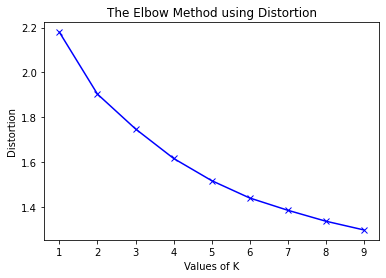

In [30]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [31]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

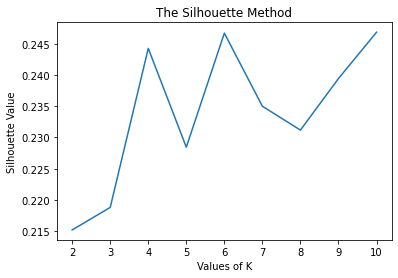

In [32]:
plt.plot(range(2,11), sil)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Value')
plt.title('The Silhouette Method')
plt.show()

In [33]:
from sklearn.mixture import GaussianMixture
def get_bic_aic(k, X):
    gmm = GaussianMixture(n_components=k, init_params='kmeans')
    gmm.fit(X)
    return gmm.bic(X), gmm.aic(X)

In [34]:
bicaiclist = []
biclist = []
aiclist = []
for i in range(1, 20):
    bicaiclist.append(get_bic_aic(i,X))
for i in bicaiclist:
    biclist.append(i[0])
for i in bicaiclist:
    aiclist.append(i[1])

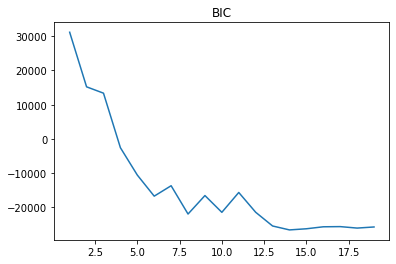

In [35]:
plt.plot(range(1,20), biclist)
plt.title('BIC')
plt.show()

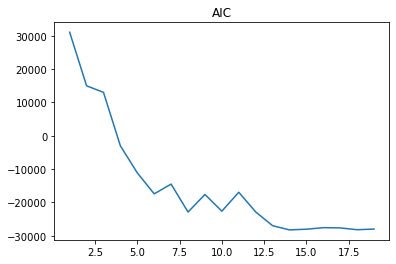

In [36]:
plt.plot(range(1,20), aiclist)
plt.title('AIC')
plt.show()

# Running KMeans

In [37]:
kmeans_group2 = KMeans(n_clusters=2).fit(Kmean_df)
array_group2 = kmeans_group2.labels_
group2 = standardized_df.copy()
group2['cluster'] = array_group2
group2.groupby("cluster").mean()

,Age,Income,MntWines,Kids,Teens,Enroll_age,Recency,Graduation,PhD,Master,Cycle,Basic,Married,Together,Single,Divorced,Widow,Others,Mnt/Income,MntWines/AllProducts
cluster,,,,,,,,,,,,,,,,,,,,
0,-0.817168,-0.189144,-0.172989,0.321980,-0.892334,0.009552,-0.017617,0.518272,0.174972,0.145072,0.114064,0.0,0.395349,0.248062,0.264673,0.084164,0.005537,0.002215,-0.225390,-0.505417
1,0.561998,0.130082,0.118971,-0.221438,0.613692,-0.006569,0.012116,0.493526,0.246002,0.178218,0.073877,0.0,0.380807,0.265804,0.176695,0.118812,0.054075,0.003808,0.155009,0.347595


In [38]:
kmeans_group5 = KMeans(n_clusters=5).fit(Kmean_df)
array_group5 = kmeans_group5.labels_
group5 = Kmean_df.copy()
group5['cluster'] = array_group5
group5['MntWines/Income'] = standardized_df['Mnt/Income']
group5['MntWines/AllProducts'] = standardized_df['MntWines/AllProducts']
group5.groupby('cluster').mean()

,Age,Kids,Teens,Enroll_age,Recency,MntWines/Income,MntWines/AllProducts
cluster,,,,,,,
0,0.405489,-0.823039,0.994029,-0.071646,-0.006825,-0.031031,-0.044529
1,-1.013280,-0.823039,-0.928972,-0.078256,-0.103551,-0.007063,-0.015544
2,-0.802664,1.101674,-0.928972,0.026984,0.000372,0.038003,0.034721
3,0.296117,1.168880,1.001187,0.086490,0.014077,0.001105,0.036259
4,1.100530,-0.817144,-0.923156,0.067657,0.099283,0.003432,0.005077


# Analyze

In [39]:
cluster0 = group2[group2['cluster'] == 0]
cluster0
cluster0data = cluster0[["Age", "Kids", 'Teens', 'Enroll_age', 'Mnt/Income', 'MntWines/AllProducts','Recency', 'Graduation', 'PhD', 'Master', 'Cycle', 'Basic', 'Married', 'Together', 'Single', 'Divorced', 'Widow', 'Others']].describe()

In [40]:
cluster1 = group2[group2['cluster'] == 1]
cluster1.get('Age').count()
#cluster1data = cluster1[["Age", "Kids", 'Teens', 'Enroll_age', 'MntWines/Income', 'MntWines/AllProducts', 'Recency', 'Graduation', 'PhD', 'Master', 'Cycle', 'Basic', 'Married', 'Together', 'Single', 'Divorced', 'Widow', 'Others']].describe()

1313

In [41]:
cluster0.to_csv('cluster0data.csv')
cluster1.to_csv('cluster1data.csv')

In [42]:
cluster1.get('Age').mean(), cluster0.get('Age').mean(), cluster1.get('Mnt/Income').mean(), cluster0.get('Mnt/Income').mean()

(0.5619977682385181,
 -0.8171684049802613,
 0.15500940791141202,
 -0.22539020220120054)

In [43]:
group2.to_csv('twoclusters1.csv')

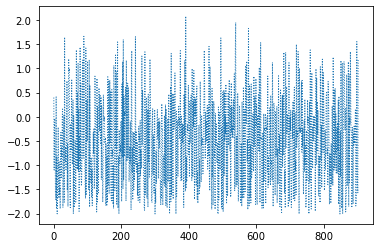

In [44]:
plt.plot(np.arange(903),cluster0['MntWines/AllProducts'],ls = 'dotted',lw=1)

In [45]:
-0.218213494 * np.std(cleaned_marketing_campaign["Kidhome"]) + np.mean(cleaned_marketing_campaign["Kidhome"])

0.32465543668556696

In [46]:
0.313172334 * np.std(cleaned_marketing_campaign["Kidhome"]) + np.mean(cleaned_marketing_campaign["Kidhome"])

0.6098901100057

In [47]:
0.621960226 * np.std(cleaned_marketing_campaign["Teenhome"]) + np.mean(cleaned_marketing_campaign["Teenhome"])

0.8437978560335309

In [48]:
-0.892615445 * np.std(cleaned_marketing_campaign["Teenhome"]) + np.mean(cleaned_marketing_campaign["Teenhome"])

0.019780219925587483

In [49]:
0.562853864 * np.std(age) + np.mean(age)

58.924196014243

In [50]:
-0.807788073 * np.std(age) + np.mean(age)

42.50000000532684

In [51]:
0.00842632 * np.std(cleaned_marketing_campaign["Recency"]) + np.mean(cleaned_marketing_campaign["Recency"])

49.25650840947596

In [52]:
-0.012093159 * np.std(cleaned_marketing_campaign["Recency"]) + np.mean(cleaned_marketing_campaign["Recency"])

48.66263735707603

In [53]:
0.127460685 * np.std(cleaned_marketing_campaign["Income"]) + np.mean(cleaned_marketing_campaign["Income"])

55455.104909815804

In [54]:
-0.182927092 * np.std(cleaned_marketing_campaign["Income"]) + np.mean(cleaned_marketing_campaign["Income"])

47643.45275843905

In [55]:
cleaned_marketing_campaign["Kidhome"] - np.mean(cleaned_marketing_campaign["Kidhome"])/np.std(cleaned_marketing_campaign["Kidhome"])

0      -0.823039
1       0.176961
2      -0.823039
3       0.176961
4       0.176961
          ...   
2235   -0.823039
2236    1.176961
2237   -0.823039
2238   -0.823039
2239    0.176961
Name: Kidhome, Length: 2216, dtype: float64